# Load Dataset

In [1]:
import numpy as np
import cv2
import os

In [2]:
dir = '../dataset/trainingSample/trainingSample/'
images = []
labels = []
for label in os.listdir(dir):
    for image in os.listdir(dir + label + '/'):
        images.append(cv2.imread(dir + label + '/' + image, cv2.IMREAD_GRAYSCALE) / 255.)
        labels.append(int(label))
images = np.array(images)
images = images.reshape(images.shape[0], images.shape[1], images.shape[2], 1)
labels = np.array(labels)
labels = labels.reshape(labels.shape[0], 1)

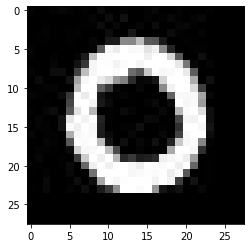

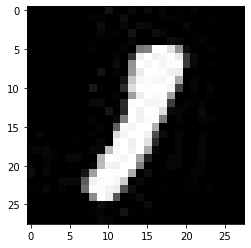

In [3]:
import matplotlib.pyplot as plt

plt.imshow(images[0].reshape(28, 28), cmap='gray')
plt.show()
plt.imshow(images[100].reshape(28, 28), cmap='gray')
plt.show()

# Split Dataset

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, shuffle=True)

# Create model

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, Input
from tensorflow.keras.models import Model

In [7]:
def create_model():
    input_image = Input(shape=(28, 28, 1))
    
    # encoded
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_image)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same', name='encoder')(x)
    
    # decoded
    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(16, (3, 3), activation='relu')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='decoder')(x)
    
    model = Model(input_image, x)
    
    return model

In [8]:
model = create_model()
model.compile(optimizer='adadelta',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False))

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
encoder (MaxPooling2D)       (None, 4, 4, 8)           0     

# Training model

In [10]:
import datetime
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [19]:
history = model.fit(x=X_train, 
                    y=X_train, 
                    epochs=100000, 
                    validation_data=(X_test, X_test),
                    batch_size=16,
                    shuffle=True,
                    verbose=0,
                    callbacks=[tensorboard_callback])

KeyboardInterrupt: 

# Start Tensorboard

In [ ]:
!taskkill /im tensorboard.exe /f
!del /q %TMP%\.tensorboard-info\*
%reload_ext tensorboard
%tensorboard --logdir logs --host 127.0.0.1 --port 6066

# Testing model

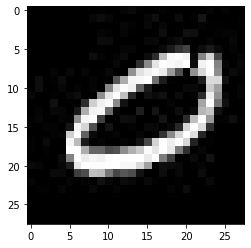

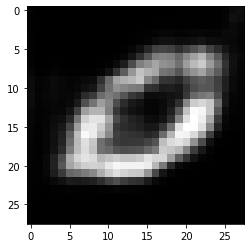

In [20]:
result = model.predict(images[15].reshape(1, 28, 28, 1))

plt.imshow(images[15].reshape(28, 28), cmap='gray')
plt.show()
plt.imshow(result.reshape(28, 28) * 255, cmap='gray')
plt.show()

In [21]:
def get_encoder_decoder(autoencoder, encoded_layer):
    # encoder
    encoder_input = autoencoder.layers[0].input
    encoder = Model(encoder_input, autoencoder.layers[encoded_layer].output)
    
    # decoder
    decoder_input = x = Input(shape=autoencoder.layers[encoded_layer].output_shape[1:])
    for layer in autoencoder.layers[encoded_layer + 1:]:
        x = layer(x)
    decoder = Model(decoder_input, x)
    
    return encoder, decoder

In [22]:
encoder, decoder = get_encoder_decoder(model, 6)

(1, 4, 4, 8)


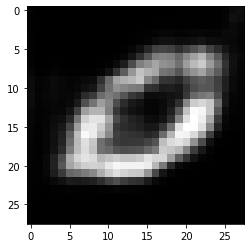

In [23]:
tmp = encoder.predict(images[15].reshape(1, 28, 28, 1))
print(tmp.shape)
result = decoder.predict(tmp)
plt.imshow(result.reshape(28, 28) * 255, cmap='gray')
plt.show()

# Save model

In [ ]:
tf.saved_model.save(model, 'save_model')

# Load model

In [ ]:
new_model = tf.keras.models.load_model('save_model')

In [ ]:
new_model.summary()

# Save Frozen model

In [24]:
# Get frozen ConcreteFunction
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

In [25]:
def save_frozen_model(model, logdir='frozen_models', name='frozen_graph.pb'):
    # Convert Keras model to ConcreteFunction
    full_model = tf.function(lambda x: model(x))
    full_model = full_model.get_concrete_function(
        x=tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))
    frozen_func = convert_variables_to_constants_v2(full_model)
    tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                  logdir=logdir,
                  name=name,
                  as_text=False)

In [26]:
save_frozen_model(model, name='autoencoder_frozen_graph.pb')
save_frozen_model(encoder, name='encoder_frozen_graph.pb')
save_frozen_model(decoder, name='decoder_frozen_graph.pb')